# Overfitting

Earlier we had seen how to train a multi-layered perceptron using Pytorch. In this notebook we will see few issues that arise when training a neural network. Specifically, we will focus our attention on the problem of overfitting, where a neural network learns the quirks of the training data, rather than information that is generalizable to the task at hand. 

We will see how to identify overfitting during the training process. Next, we will study few ways by which one can reduce overfitting, including:
- Early stopping
- Data augmentation
- Weight decay
- Dropout

We will use the MNIST digit recognition problem as a running example. Since we are studying overfitting, we will artificially reduce the number of training examples to 20.

In [ ]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

# for reproducibility
torch.manual_seed(1)

Number of training images: 20
Number of validation images: 5000
Number of test images: 10000


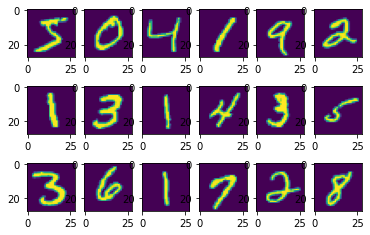

In [ ]:
# import handwritten digit dataset
mnist_trainval_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_test_data = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

mnist_data = list(mnist_trainval_data)
mnist_test = list(mnist_test_data)
mnist_train = mnist_data[:20]
mnist_val = mnist_data[100:5100]

print('Number of training images: {}'.format(len(mnist_train)))
print('Number of validation images: {}'.format(len(mnist_val)))
print('Number of test images: {}'.format(len(mnist_test_data)))

# plot the first 18 images in the training data
for k, (image, label) in enumerate(mnist_train[:18]):
    plt.subplot(3, 6, k+1)
    plt.imshow(image[0])

We will use the `MNISTClassifier` network, a MLP with two hidden layers, as our base model:

In [ ]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

Next, we will write the training and validation method

In [ ]:
def trainval(model, train_data, valid_data, device, batch_size=20, num_iters=1, learn_rate=0.01, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True) # shuffle after every epoch
    val_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)

    iters, losses, val_losses, train_acc, val_acc = [], [], [], [], []

    # training
    n = 0 # the number of iterations
    for n in range(num_iters):
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            model.train() #*****************************#
            optimizer.zero_grad()         # a clean up step for PyTorch
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter

            # save the current training information
            if n % 10 == 9:
                iters.append(n)
                losses.append(float(loss)/batch_size)        # compute *average* loss
                train_accuracy = get_accuracy(model, train_data, device)
                val_accuracy = get_accuracy(model, valid_data, device)
                for im, lb in val_loader:
                    im, lb = im.to(device), lb.to(device)
                    val_out = model(im)
                    val_loss = criterion(val_out, lb)
                val_losses.append(float(val_loss)/batch_size)
                train_acc.append(train_accuracy) # compute training accuracy 
                val_acc.append(val_accuracy)   # compute validation accuracy

    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.plot(iters, val_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


def get_accuracy(model, data, device):
    correct = 0
    total = 0

    model.eval() #*********#
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
        accuracy = correct / total
    return accuracy

We will now check the training and validation loss and accuracy

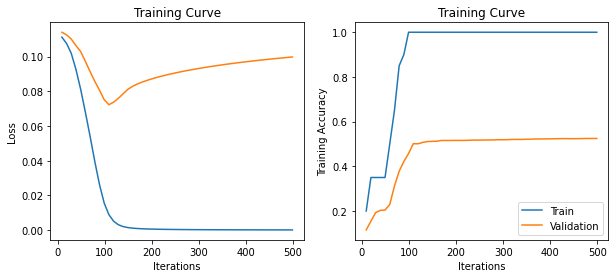

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5246


In [ ]:
model = MNISTClassifier()

# Ship data and model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

trainval(model, mnist_train, mnist_val, device, num_iters=500)

We observe that without any intervention, our model gets to about 52-53% accuracy on the validation set.

## Early stopping
One way to mitigate the issue of overfitting is to stop the training when the network starts to overfit. We do not use the trained weights from the last training iteration as our "final" model. Instead, we used a model (a set of weights) from a previous iteration of training. We choose the iteration/epoch to use based on the training curve and validation curve. The point of inflection
in the validation loss is used to decide which iteration should be chosen.

## Data Preprocessing

A simple solution to overfitting is adding more data to the training set. While it is often expensive to gather more data, we can often programmatically "generate" more data points from our existing data set. We can make small alterations to our training set to obtain slightly different input data, but that is still valid. Common ways of obtaining new (image) data include:

Flipping each image horizontally or vertically (won't work for digit recognition, but might for other tasks)
Shifting each pixel a little to the left or right
Rotating the images a little
Adding noise to the image
... or even a combination of the above. For demonstration purposes, let's randomly rotate our digits a little to get new training samples.

Here are the 20 images in our training set:

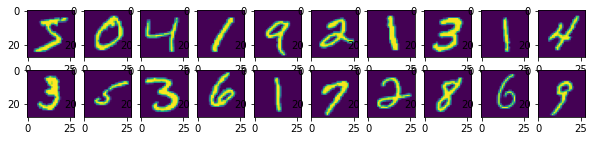

In [ ]:
def show20(data):
    plt.figure(figsize=(10,2))
    for n, (img, label) in enumerate(data):
        if n >= 20:
            break
        plt.subplot(2, 10, n+1)
        plt.imshow(img)

mnist_imgs = datasets.MNIST('data', train=True, download=True)
show20(mnist_imgs)

Here are the 20 images in our training set, each rotated randomly, by up to 25 degrees.

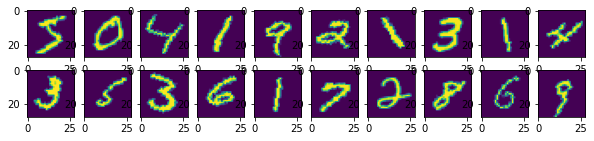

In [ ]:
mnist_new = datasets.MNIST('data', train=True, download=True, 
                           transform=transforms.RandomRotation(25))
show20(mnist_new)

If we apply the transformation again, we can get images with different rotations:

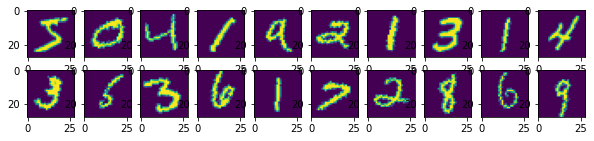

In [ ]:
mnist_new = datasets.MNIST('data', train=True, download=True, transform=transforms.RandomRotation(25))
show20(mnist_new)

We can augment our data set by, say, randomly rotating each training data point 10 times:

In [ ]:
augmented_train_data = []

my_transform = transforms.Compose([
    transforms.RandomRotation(25),
    transforms.ToTensor(),
])

for i in range(10):
    mnist_new = datasets.MNIST('data', train=True, download=True, transform=my_transform)
    for j, item in enumerate(mnist_new):
        if j >= 20:
            break
        augmented_train_data.append(item)

len(augmented_train_data)

200

We obtain a better validation accuracy after training on our expanded dataset.

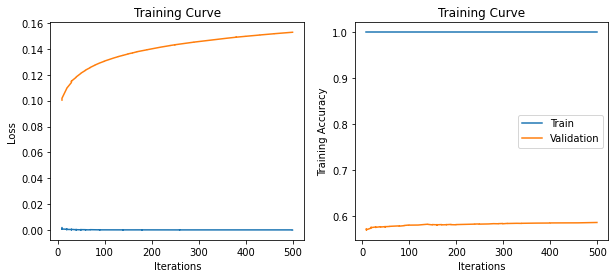

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5858


In [ ]:
trainval(model, augmented_train_data, mnist_val, device, num_iters=500)

## Weight Decay

A more interesting technique that prevents overfitting is the idea of weight decay. The idea is to penalize large weights. We avoid large weights, because large weights mean that the prediction relies a lot on the content of one pixel, or on one unit. Intuitively, it does not make sense that the classification of an image should depend heavily on the content of one pixel, or even a few pixels.

Mathematically, we penalize large weights by adding an extra term to the loss function, the term can look like the following:

- $L_1$ regularization: $\sum_k |w_k|$
  - mathematically this term encourages the weights to be exactly 0.
- $L_2$ regularization: $\sum_k (w_k)^2$
  - Mathematically, in each iteration the weight is pushed towards 0.
- Combination of $L_1$ and $L_2$ regularization. This is done by adding the term $\sum_k |w_k|$ + w_k^2$ to the loss function.

In PyTorch, weight decay can also be done automatically inside an optimizer. The parameter `weight_decay` of `optim.SGD` and most other optimizers uses  $L_2$  regularization for weight decay. The value of the weight_decay parameter is another tunable hyperparameter.

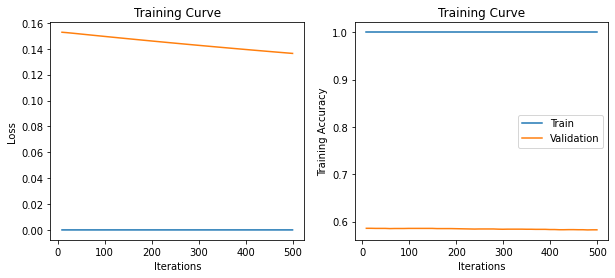

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5826


In [ ]:
trainval(model, mnist_train, mnist_val, device, num_iters=500, weight_decay=0.001)

## Dropout

Yet another way to prevent overfitting is to build many models, then average their predictions at test time. Each model might have a different set of initial weights.

We won't show an example of model averaging here. Instead, we will show another idea that sounds drastically different on the surface.

This idea is called dropout: we will randomly "drop out", "zero out", or "remove" a portion of neurons from each training iteration.


In different iterations of training, we will drop out a different set of neurons.

The technique has an effect of preventing weights from being overly dependent on each other: for example for one weight to be unnecessarily large to compensate for another unnecessarily large weight with the opposite sign. Weights are encouraged to be "more independent" of one another.

During test time though, we will not drop out any neurons; instead we will use the entire set of weights. This means that our training time and test time behaviour of dropout layers are different. In the code for the function train and get_accuracy, we use model.train() and model.eval() to flag whether we want the model's training behaviour, or test time behaviour.

While unintuitive, using all connections is a form of model averaging! We are effectively averaging over many different networks of various connectivity structures.

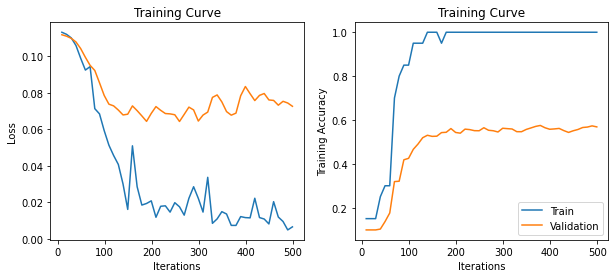

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5684


In [ ]:
class MNISTClassifierWithDropout(nn.Module):
    def __init__(self):
        super(MNISTClassifierWithDropout, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
        self.dropout1 = nn.Dropout(0.4) # drop out layer with 40% dropped out neuron
        self.dropout2 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.4)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = F.relu(self.layer1(self.dropout1(flattened)))
        activation2 = F.relu(self.layer2(self.dropout2(activation1)))
        output = self.layer3(self.dropout3(activation2))
        return output

model = MNISTClassifierWithDropout()
model.to(device)

trainval(model, mnist_train, mnist_val, device, num_iters=500)

# Excercise

Write a code to incorporate all of the methods discussed above and report the accuracy.

In [ ]:
### Your Code Here ###